In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


packages required for this notebook:
* `sklearn` (http://scikit-learn.org/stable/)
* `ghalton` (https://pypi.python.org/pypi/ghalton) 

# Earthquake scenario generation for PTHA

PTHA requires running tsunami simulations for many potential earthquakes and combining the results based on the annual probability of each scenario. While it is certainly possible to perform Monte Carlo sampling directly, the sampling algorithms require many hundreds of thousands of runs and the computational cost of the tsunami simulations can quickly become substantial. 

In this section, we develop a methodology that, for a given computational budget and earthquake magnitude, provides a catalogue of earthquake scenarios along with the corresponding annual probabilities. We assume that computational budget is given as the number of tsunami simulations that can be performed. Throughout this section, we will use the computational budget of $N=100$ runs, however, nothing prevents the method from generating scenarios of different size.

Here we utilize the K-L expansion of the log-normal slip distribution $\mathbf{s}$ [cite KLpaper] which can be written as
$$
\mathbf{s} = \exp\left[\sum_{j=0}^{\infty} z_j \sqrt{\lambda_j} \mathbf{v}_j \right]
\quad
\text{ where }
z_j \sim \mathcal{N}(0,1).
$$
This expansion reduces the problem of earthquake generation (with prescribed spatial correlation parameters) to generating samples from
the normal distribution $\mathcal{N}(0,1)$.

In the proposed methodology, $N$ Scenarios are generated in the following steps.
1. Generate Halton sequence (quasi Monte Carlo samples) of sufficient length, say $200N$, from the normal distribution $\mathcal{N}(0,I)$.
2. Perform $k$-means clustering to find $N$ centroids of the $200N$ samples, using Lloyd's algorithm, for example.
3. Dilate these samples, so that tails are covered-well, up to $m$ standard deviations, for example $m = 4$. These centroids are scattered to cover the distribution $\mathcal{N}(0,mI)$ well, effectively representing the tail-regions of $\mathcal{N}(0,I)$ with the given number $N$ of samples.
4. Assign probability weights for each of these samples, by using the Voronoi diagram generated by $k$-means clustering in step 2.

## Scenario generation example

Here we demonstrate the scenario generation methodology proposed above. To give a more concrete example, we will first assume that the computational budget $N=100$ and that we will be concerned with events within $m=4$ standard deviations. We will also assume that the K-L expansion above will be truncated to include up to 20 terms, (the constant term will be designated by the user.)
$$
\mathbf{s} \sim \sum_{j=1}^{20} z_j \sqrt{\lambda_j} \mathbf{v}_j
\quad
\text{ where }
z_j \sim \mathcal{N}(0,1).
$$
Therefore, we will be sampling a 20-dimensional probability distribution

In [2]:
from sklearn import cluster
import ghalton
import numpy as np
import os
import matplotlib.pyplot as pl
from scipy.special import erfinv

First, we generate Halton sequence of length 20,000 in dimension 20, to obtain low-discrepancy samples $\sim \mathcal{U}[0,1]^{60}$. Figure below shows the generated Halton sequence projected onto the first 2 variables.

In [3]:
# helper function for the the inv error-function
def icdf(x):
    return erfinv(2.*x - 1.)


ndim = 20
nsamples = 100
sequencer = ghalton.Halton(ndim)
sequencer.seed(12345)
hpts = np.array(sequencer.get(nsamples))


pts = icdf(hpts)

In [4]:
theta = np.linspace(0,2*np.pi,200)
ct = np.cos(theta)
st = np.sin(theta)

(-0.1, 1.1)

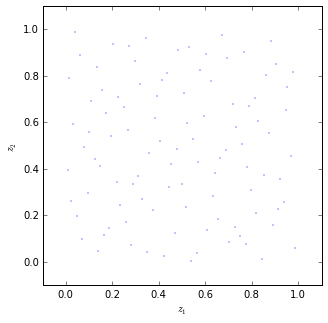

In [5]:
figure(figsize=(5,5));
plot(hpts[:,0],hpts[:,1],'.',markersize=1);
xlabel('$z_1$');
ylabel('$z_2$');
xlim([-0.1, 1.1])
ylim([-0.1, 1.1])


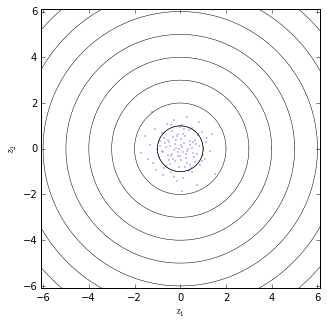

In [6]:
x0 = 6.
y0 = 6.
figure(figsize=(5,5));
plot(ct,st,'-k',linewidth=0.5);
for k in range(int(x0)+4):
    plot(k*ct,k*st,'-k',linewidth=0.5,label=str(k));
plot(pts[:,0],pts[:,1],'.',markersize=1);
xlim((- x0 - 0.1, x0 + 0.1))
ylim((- y0 - 0.1, y0 + 0.1))
xlabel('$z_1$');
ylabel('$z_2$');

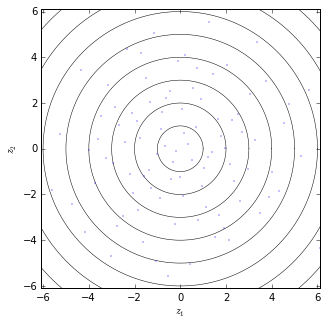

In [7]:
x0 = 6.
y0 = 6.
sigma0 = 4.0
figure(figsize=(5,5));
for k in range(int(x0)+4):
    plot(k*ct,k*st,'-k',linewidth=0.5);
plot(sigma0*pts[:,0],sigma0*pts[:,1],'.',markersize=1);
xlim((- x0 - 0.1, x0 + 0.1))
ylim((- y0 - 0.1, y0 + 0.1))
xlabel('$z_1$');
ylabel('$z_2$');
savefig('qMCsamples.png',dpi=100)

We use inverse error function to transform the Halton sequence into normal samples $\sim \mathcal{N}(0,I)$. The quasi Monte Carlo samples are shown in Figure []. Then, we dilate the samples to cover the tail of the distribution, up to $m=4$ standard deviations,
$$
\tilde z \equiv 4 z 
\quad \text{ so that }
\tilde z \sim \mathcal{N}(0, 4I).
$$
Recall that the slip distribution is drawn from a log-normal distribution. Therefore, while $z_j$ is drawn from the normal distribution $\mathcal{N}(0,1)$, it needs to be exponentiated to produce the slip distribution. In this light, the dilation of the samples for importance sampling above []
by $m$, i.e. $\tilde z_j \equiv m z_j$ can be rewritten,
$$
\mathbf{s} \sim \exp\left[ \sum_{j=1}^{20} \tilde z_j \sqrt{\lambda_j} \mathbf{v}_j \right] = \exp\left[ \sum_{j=1}^{20} m z_j \sqrt{\lambda_j} \mathbf{v}_j \right]
= \left(\exp\left[ \sum_{j=1}^{20} z_j \sqrt{\lambda_j} \mathbf{v}_j \right]\right)^m.
$$
This reveals that the dilation by $m$ has the effect of taking the power of the slip distribution. Then this is tapered the normalized [cite KLpaper].


Each of these sample points correspond to a potential earthquake scenario, therefore we have so far obtained a catalogue of 20,000 potential earthquake scenarios (corresponding probability weights have not yet been assigned.) Since we are constrained by the computational budget, we must reduce the number of scenarios to $N=100$. To this end, we do a $k$-means clustering of the large number of scenarios, to a prescribed number of clusters. There are various clustering algorithms that enable this, for example, the well-known Lloyd's algorithm [cite reference]. The cluster centers will each represent an earthquake scenario which will be used for the tsunami simulation. The cluster centers are shown in Figure [].

In [8]:
sigma0 = 4.0
fitpts = np.zeros((nsamples,ndim))
fitpts = sigma0*pts

kmeans_model = cluster.KMeans(n_clusters=100, random_state=1).fit(fitpts)
scenario_pts = kmeans_model.cluster_centers_

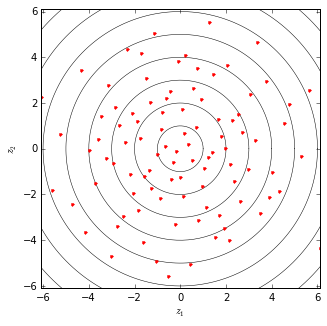

In [9]:
x0 = 6.
y0 = 6.
sigma0 = 4.0
figure(figsize=(5,5));
for k in range(int(x0)+4):
    plot(k*ct,k*st,'-k',linewidth=0.5);
plot(scenario_pts[:,0],scenario_pts[:,1],'.r');
xlim((- x0 - 0.1, x0 + 0.1))
ylim((- y0 - 0.1, y0 + 0.1))
xlabel('$z_1$');
ylabel('$z_2$');
savefig('cluster.png',dpi=100)

The remaining task is to assign probability weights to each of the earthquake scenarios. These earthquake scenarios can be interpreted to be *importance samples* drawn from $\mathcal{N}(0,4I)$ and hence probability weights must be multiplied for them to be used for sampling $\mathcal{N}(0,I)$. We achieve this by using the prediction from $k$-means clustering in conjunction with straightforward Monte Carlo Sampling. For each MC sample drawn from $\mathcal{N}(0,I)$ the $k$-means prediction assigns a cluster center. The number of MC samples that fall for each cluster center is proportional to the probability weight to be assigned to each scenario. Let us denote the prediction $I_k: \mathbb{R}^{20} \to \{0,1\}$ for sample $z_\ell$ by $I_k(z_\ell)$, and the $k$-th cluster by $C_k$,
$$
I(z) = \begin{cases} 1 & \text{ if } z \in C_k \\
                     0 & \text{ otherwise. }
       \end{cases}.
$$
Then the probability weights are approximated by
$$
p_k \sim \frac{1}{M}\sum_{\ell=1}^M I_k(z_\ell)
$$
Since the higher-order terms in the K-L expansion do not significantly affect the tsunami resulting from the earthquake, one may compute of the probability weights based on the 7-dimensional $\mathcal{N}(0,I)$ for computational efficiency.

Compute the probability weights to be assigned to each cluster center

In [10]:
wgts = np.zeros(100)
neval_pts = 1500000
# eval_pts = np.array(ghalton.Halton(ndim).get(neval_pts))
# eval_pts = icdf(eval_pts)

eval_pts = np.random.randn(neval_pts,20)
ii,unordered_wgts = np.unique(kmeans_model.predict(eval_pts), return_counts=True)
unordered_wgts = unordered_wgts/ float(unordered_wgts.sum())

for k,ic in enumerate(ii):
    wgts[ic] = unordered_wgts[k]

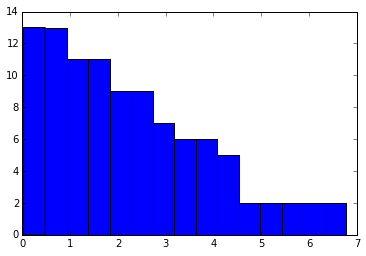

In [11]:
L0 = 4
L1 = 5
x = np.linalg.norm(scenario_pts[:,L0:L1],axis=1)
pl.hist(x,bins=15);

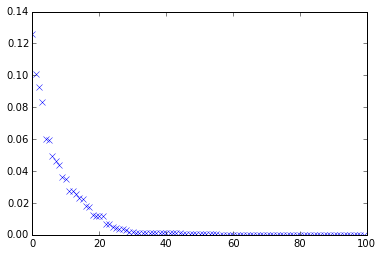

In [12]:
pl.plot(np.sort(wgts)[::-1],'x');

Save output to textfiles: 
- `scenario_pts.txt` : 100 scenario points
- `wgts.txt` : corresponding 100 weights

In [13]:
if os.path.exists('scenario_pts.txt') or os.path.exists('scenario_prb_wgts.txt'):
    print('scenario_pts.txt or scenario_prb_wgts.txt exists! Saving to ..._new.txt')
    print('these must be replaced with the old .txt files for run_CC_CSZ_South.py ')
    print('be able to read them.')
    np.savetxt('scenario_pts_new.txt',scenario_pts)
    np.savetxt('scenario_prb_wgts_new.txt',wgts)    
else:
    np.savetxt('scenario_pts.txt',scenario_pts)
    np.savetxt('scenario_prb_wgts.txt',wgts)

scenario_pts.txt or scenario_prb_wgts.txt exists! Saving to ..._new.txt
these must be replaced with the old .txt files for run_CC_CSZ_South.py 
be able to read them.
